In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.io import loadmat

C:\Users\Conor\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Conor\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Digitising secondary protein spectra

In [2]:
secondary_protein_file = r"C:\Users\Conor\Google Drive\PhD\Secondary_Protein_Structures"

Structures = ["DNA","Glycogen","Lipid","Protein","RNA"]

Data = {Name: pd.read_csv(os.path.join(secondary_protein_file, "{}.csv".format(Name)), names = ["Wavenumber", "Absorbance"]).set_index("Wavenumber") for Name in Structures}

<Figure size 432x288 with 0 Axes>

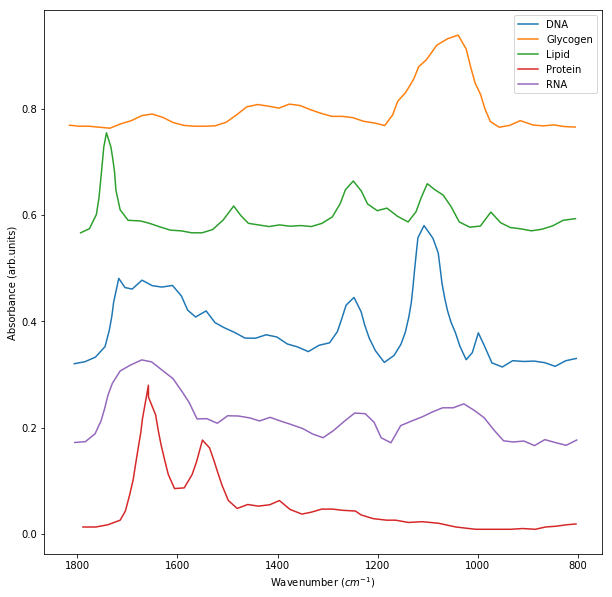

In [3]:
plt.clf()
fig = plt.figure(figsize = (10,10))
fig.patch.set_facecolor([1,1,1])

for name, df in Data.items():
    
    plt.plot(df, label = name)

plt.xlabel("")
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("Wavenumber $(cm^{-1}$)")
plt.ylabel("Absorbance (arb.units)")
plt.show()

Importing FTIR cubes

In [4]:
import os

file_place = r"C:\Users\Conor\Desktop\Breast Cancer Data\br20832_cores\br20832_cores"
file_list = os.listdir(file_place)

image_list_directory = r"C:\Users\Conor\Desktop\Breast Cancer Data\overlay\overlay"
image_list = os.listdir(image_list_directory)

images = {file_name[:-4] : loadmat(os.path.join(file_place, file_name)) for file_name in file_list[:3]}

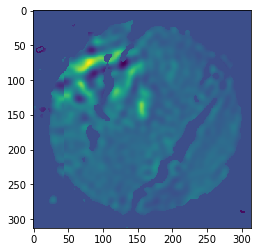

In [5]:
from scipy.io import loadmat

mat = loadmat(file_place + "\\" + os.listdir(file_place)[9])

mat["image"].shape

plt.clf()
#plt.imshow(mat["image"].mean(axis = 2), cmap = "viridis")
plt.imshow(mat["image"][:,:,80], cmap = "viridis")
plt.show()

Interpolate the macromolecule spectra

In [6]:
from scipy import interpolate

Secondary_Structures = {Name: interpolate.interp1d(spectrum.index, spectrum.values.flatten(), fill_value = "extrapolate") for Name, spectrum in Data.items()}

In [7]:
Secondary_Structures

{'DNA': <scipy.interpolate.interpolate.interp1d at 0x2965e461138>,
 'Glycogen': <scipy.interpolate.interpolate.interp1d at 0x2965e2434f8>,
 'Lipid': <scipy.interpolate.interpolate.interp1d at 0x2965f44ac28>,
 'Protein': <scipy.interpolate.interpolate.interp1d at 0x2965f44ae08>,
 'RNA': <scipy.interpolate.interpolate.interp1d at 0x2965f44aef8>}

# Secondary Protein Analysis

In [8]:
%load_ext autoreload

%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
file_place = r"C:\Users\Conor\DataSets"

Breast_DF = pd.read_pickle(file_place + r"\Breast_data_raw_ordered")#.reset_index()
Breast_DF.to_hdf(os.path.join("C:\Users\Conor\OneDrive", "\Breast_data_raw_ordered.df5"),"Breast_Data")

Breast_DF.Grade = pd.Categorical(Breast_DF.Grade, categories=["-", "1", "2","2--3", "3"], ordered=True)
Breast_DF.Stage = pd.Categorical(Breast_DF.Stage, categories=["-", "I", "IIa","IIb","IIIa","IIIb"], ordered=True)

Breast_DF.set_index(["Sex", "Type", "Stage", "Pathology", "Grade", "Label", "Age", "Core"]).to_pickle(file_place + r"\Breast_data_raw_ordered")

In [8]:
pd.__version__

'0.24.0'

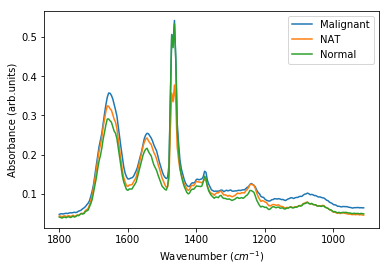

In [12]:
plt.clf()

for name, df in Breast_DF.groupby("Type"):
    
    plt.plot(df.mean(axis = 0), label = name)

plt.legend()
plt.ylabel("Absorbance (arb.units)")
plt.xlabel("Wavenumber $(cm^{-1})$")
plt.gca().invert_xaxis()
plt.show()

In [14]:
from sklearn.preprocessing import Normalizer, MinMaxScaler, RobustScaler
import Tissue_Analysis_Tools as TAT

PCA_NR_Components = 50

Normaliser = RobustScaler()#Normalizer(norm = "l1")

dataframe = TAT.process_data(Breast_DF, paraffin = (1340,1490), balance = "Type")

PCA_reduced = TAT.clean_spectra(dataframe, PCA_NR_Components)

Normalised_values = Normaliser.fit_transform(PCA_reduced.T).T
Breast_DF_P = pd.DataFrame(Normalised_values, index = dataframe.index, columns = dataframe.columns)

C:\Users\Conor\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


C:\Users\Conor\AppData\Roaming\Python\Python36\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


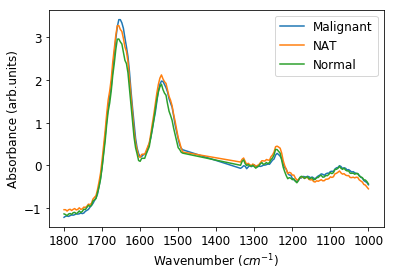

In [15]:
plt.clf()

for name, df in Breast_DF_P.groupby("Type"):
    
    plt.plot(df.mean(axis = 0), label = name)

plt.legend()
plt.ylabel("Absorbance (arb.units)")
plt.xlabel("Wavenumber $(cm^{-1})$")
plt.gca().invert_xaxis()
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

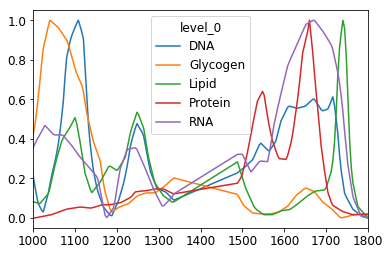

In [40]:
Normaliser = Normalizer(norm = "l1")
Normaliser = MinMaxScaler()

wavenumbers = Breast_DF_P.columns

Normed_Macros = {Name: pd.DataFrame(Normaliser.fit_transform(data(wavenumbers).reshape(1,-1).T).T, columns = wavenumbers) for Name, data in Secondary_Structures.items()}

Normed_Secondary = pd.concat(Normed_Macros, axis = 0).reset_index().drop("level_1", axis = 1).set_index("level_0")

plt.clf()
fig = plt.figure()
fig.patch.set_facecolor([1,1,1])

Normed_Secondary.T.plot()

plt.show()

In [18]:
BSP = pd.DataFrame(np.matmul(Breast_DF_P.values, Normed_Secondary.values.T)
                                         , index = Breast_DF_P.index, columns = Normed_Secondary.index)

In [19]:
Breast_DF_P.head()

1000  \
Sex Type      Stage Pathology                 Grade Label                Age Core             
F   Malignant IIIb  Invasive ductal carcinoma 2     Malignant Epithelium 45  J11  -0.553390   
              I     Invasive ductal carcinoma 1     Malignant Epithelium 42  B15  -0.241925   
              IIa   Invasive ductal carcinoma 2     Malignant Stroma     41  J9   -0.105141   
                                                    Malignant Epithelium 50  J13  -0.716629   
                                                                         61  L3   -0.206669   

                                                                                       1004  \
Sex Type      Stage Pathology                 Grade Label                Age Core             
F   Malignant IIIb  Invasive ductal carcinoma 2     Malignant Epithelium 45  J11  -0.504344   
              I     Invasive ductal carcinoma 1     Malignant Epithelium 42  B15  -0.206022   
              IIa   Invasive ductal carcinoma 2     Malignant Stroma     41  J9   -0.026342   
                                                    Malignant Epithelium 50  J13  -0.676764   
                                                                         61  L3   -0.157691   

                                                                                       1008  \
Sex Type      Stage Pathology                 Grade Label                Age Core             
F   Malignant IIIb  Invasive ductal carcinoma 2     Malignant Epithelium 45  J11  -0.498771   
              I     Invasive ductal carcinoma 1     Malignant Epithelium 42  B15  -0.182626   
              IIa   Invasive ductal carcinoma 2     Malignant Stroma     41  J9    0.051214   
                                                    Malignant Epithelium 50  J13  -0.666152   
                                                                         61  L3   -0.117939   

                                                                                       1012  \
Sex Type      Stage Pathology                 Grade Label                Age Core             
F   Malignant IIIb  Invasive ductal carcinoma 2     Malignant Epithelium 45  J11  -0.473365   
              I     Invasive ductal carcinoma 1     Malignant Epithelium 42  B15  -0.122236   
              IIa   Invasive ductal carcinoma 2     Malignant Stroma     41  J9    0.033037   
                                                    Malignant Epithelium 50  J13  -0.673536   
                                                                         61  L3   -0.071117   

                                                                                       1016  \
Sex Type      Stage Pathology                 Grade Label                Age Core             
F   Malignant IIIb  Invasive ductal carcinoma 2     Malignant Epithelium 45  J11  -0.436374   
              I     Invasive ductal carcinoma 1     Malignant Epithelium 42  B15  -0.026373   
              IIa   Invasive ductal carcinoma 2     Malignant Stroma     41  J9    0.137381   
                                                    Malignant Epithelium 50  J13  -0.627372   
                                                                         61  L3    0.004977   

                                                                                       1020  \
Sex Type      Stage Pathology                 Grade Label                Age Core             
F   Malignant IIIb  Invasive ductal carcinoma 2     Malignant Epithelium 45  J11  -0.409507   
              I     Invasive ductal carcinoma 1     Malignant Epithelium 42  B15  -0.000091   
              IIa   Invasive ductal carcinoma 2     Malignant Stroma     41  J9    0.169354   
                                                    Malignant Epithelium 50  J13  -0.633000   
                                                                         61  L3    0.034098   

                                                                                       1024

C:\Users\Conor\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

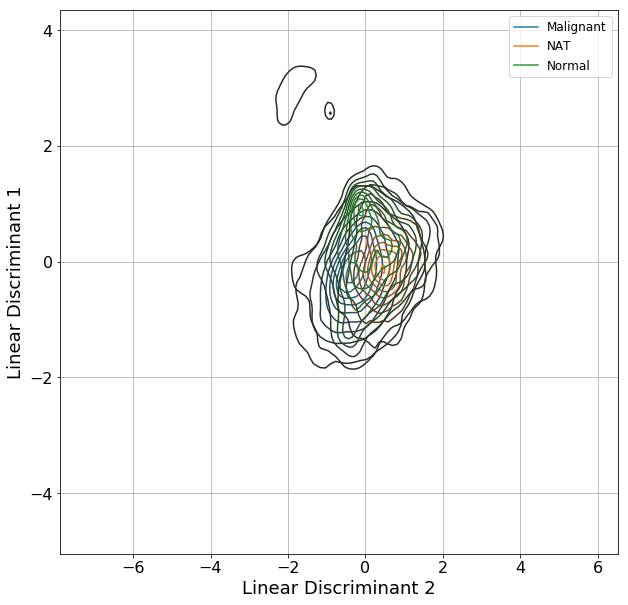

In [39]:
from sklearn.preprocessing import normalize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA, FactorAnalysis
import seaborn as sns

group = "Type"

data = BSP
#data = Breast_DF_P

# LDA
Breast_Secondary_Proteins_N = pd.DataFrame(LinearDiscriminantAnalysis(n_components = 2).fit_transform(data, data.index.get_level_values(group).to_numpy(dtype = str)), index = data.index)
# PCA
#Breast_Secondary_Proteins_N = pd.DataFrame(PCA(n_components = 2).fit_transform(data), index = data.index)
# FA
#Breast_Secondary_Proteins_N = pd.DataFrame(FactorAnalysis(n_components = 2).fit_transform(data), index = data.index)

plt.clf()
plt.figure(figsize = (10,10))
ax = plt.gca() 

for name, df in Breast_Secondary_Proteins_N.groupby(group):
    
    if name == "3": continue
    
    #df = df.sample(1000)
    sns.kdeplot(df[0], df[1], label = name)
   
ax.tick_params(labelsize=16)
plt.grid()
plt.legend()
plt.ylabel("Linear Discriminant 1", fontsize= 18)
plt.xlabel("Linear Discriminant 2", fontsize= 18)
plt.savefig(os.path.join(os.getcwd(), "FA_Plot_secondary_{}".format(group)), bbox_inches="tight")
plt.show()

<Figure size 432x288 with 0 Axes>

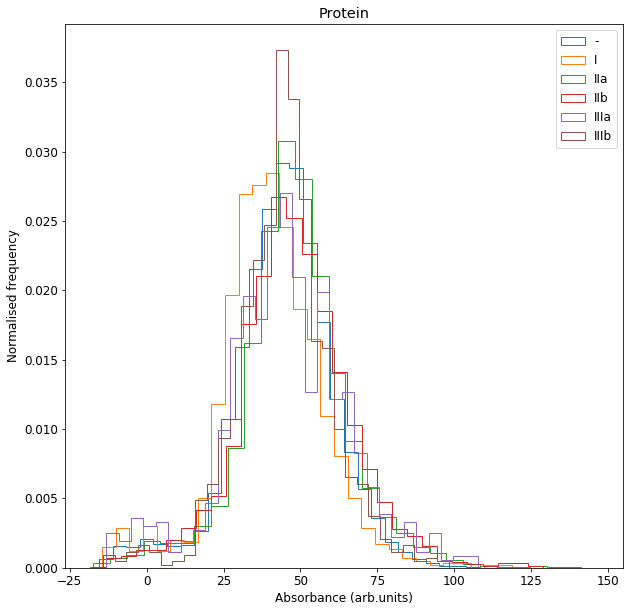

In [38]:
plt.clf()
plt.figure(figsize = (10,10))

groups = "Stage"
macro = "Protein"

for name, df in BSP.groupby(groups):
    
    if name == "3": continue
        
    #if "Epithelium" not in name: continue
    
    plt.hist(df[macro], label = name, histtype = "step", density = True, bins = 30)
    #df = df.sample(500)
    #plt.scatter(df[0],df[1], label = name, alpha = 0.5)
    
plt.title("{}".format(macro))
plt.legend()
plt.ylabel("Normalised frequency")
plt.xlabel("Absorbance (arb.units)")
#plt.xlim()
plt.show()

In [23]:
import seaborn as sns

molecule = "Lipid"
Grouping = "Stage"

for molecule in BSP.columns:
    for Grouping in ["Type", "Stage", "Grade"]:
        plt.clf()
        plt.figure(figsize = (15,10))
        ax = sns.boxplot(x=molecule, y=Grouping, data=BSP.reset_index())
        ax.tick_params(labelsize=16)
        plt.xlabel("{} similarity".format(molecule), fontsize= 18)
        plt.ylabel("{}".format(Grouping), fontsize= 18)
        plt.grid()
        #plt.savefig(os.path.join(os.getcwd(),"Boxplots_{},{}".format(Grouping, molecule)), bbox_inches="tight")
        #plt.show()

In [2]:
plt.clf()
plt.imshow(BSP.corr(method = "pearson"))
#plt.yticks(BSP.columns.values)
#plt.xticks(BSP.columns.values)
plt.colorbar()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
plt.clf()
plt.imshow(Breast_DF_P.corr(method = "pearson"))
plt.show()

# Analysis

In [ ]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

le = LabelEncoder()
lb = LabelBinarizer()

DATA = Breast_DF_P.sample(1000)

y_label = "Type"

X = DATA
Y = DATA.reset_index()[y_label]
Y_b = lb.fit_transform(Y)

In [26]:
DATA.reset_index()["Type"].value_counts()

Malignant    18901
NAT          18901
Normal       18901
Name: Type, dtype: int64

In [27]:
from sklearn.metrics import confusion_matrix


def sensitivity_Score(y, y_pred, **kwargs):
    
    assert np.unique(y).size == 2, "Non_binary sensitivity score"
    
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    return tp/(tp+fn)


def specificity_Score(y, y_pred, **kwargs):
    
    assert np.unique(y).size == 2, "Non_binary speificity score"
    
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    return tn/(tn+fp)

In [28]:
import xgboost as xgb

In [44]:
from scipy import stats

param_dist = {'n_estimators': stats.randint(50, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3],
              'early_stopping_rounds': [10] 
             }

In [31]:
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, GroupShuffleSplit, LeavePGroupsOut, LeaveOneGroupOut

In [32]:
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score, auc, accuracy_score

scorers = {
    "Accuracy": make_scorer(accuracy_score, greater_is_better = True)
    ,"Specificity": make_scorer(specificity_Score)
    ,"Sensitivity": make_scorer(sensitivity_Score, greater_is_better = True)
    ,"AUC": make_scorer(roc_auc_score)
          }

In [ ]:
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

if __name__ == '__main__':
    
    % time

    n_Folds = 2

    results = dict()

    for i, name in enumerate(np.unique(Y)):

        # Find out the ratio of positive classes to negative to scale positive weights.
        # Allows for compensation of unbalanced classes without throwing away data.

        pos_ratio = 1/(np.sum(Y_b[:,i])/Y_b[:,i].shape[0])

        clf_xgb = xgb.XGBClassifier(objective = "binary:logistic", n_classes = 2, scale_pos_weight = pos_ratio)
        #clf_LDA = LinearDiscriminantAnalysis()

        clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist
                                 , n_iter = 1, scoring = scorers, refit = "AUC"
                                 , error_score = 0, verbose = 3
                                 , n_jobs = -1, return_train_score = True
                                 , cv = GroupKFold(n_Folds).split(X, Y_b[:,i], DATA.reset_index()["Core"])
                                )

        results[name] = clf.fit(X,Y_b[:,i])

Wall time: 0 ns
Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [ ]:
import datetime

d = datetime.datetime.now().strftime("%d/%m/%Y_%H:%M:%S")

output = pd.concat({label: pd.DataFrame(results[label].cv_results_) for label in np.unique(Y)})

save_name = r"C:\Users\Conor\Documents\Projects\Biospec_Analysis\Output\{}_Balanced_Data_{}".format(y_label, d)

results.to_pickle(os.path.join(save_name, ".pickle"))
output.to_csv(os.path.join(save_name, ".csv"))